In [10]:
!pip install gymnasium[box2d] gymnasium[classic-control] stable-baselines3[extra]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (box2d-py)


In [11]:
!pip install gymnasium stable-baselines3[extra]


In [12]:
!pip install matplotlib pandas ta


In [2]:
# 1. Install the yfinance library
!pip install yfinance

# 2. Import necessary libraries
import yfinance as yf
import os
from datetime import datetime

# 3. Define the list of tickers
# Note: United Technologies (UTX) is now Raytheon Technologies (RTX)
tickers = [
    'AAPL', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DIS', 'DOW', 'GS', 'HD',
    'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE',
    'PFE', 'PG', 'TRV', 'UNH', 'RTX', 'V', 'VZ', 'WBA', 'WMT', 'XOM',
    'TSLA', 'AMZN', 'GOOGL'
]

# 4. Define the date range
start_date = '2015-01-01'
end_date = '2025-09-30'

# 5. Create a directory to store the CSV files
output_dir = 'stock_data_csv'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory '{output_dir}' created.")

# 6. Loop through tickers to download and save data
print("\nStarting data download...")
for ticker in tickers:
    try:
        # --- THIS IS THE CORRECTED PART ---
        # Use the Ticker object for a clean download
        stock = yf.Ticker(ticker)
        data = stock.history(start=start_date, end=end_date)
        # --------------------------------

        if data.empty:
            print(f"⚠️ No data found for {ticker}, skipping.")
            continue

        # Remove timezone information from the index to prevent issues
        data.index = data.index.tz_localize(None)

        # Drop columns we don't need for the model (optional, but good practice)
        if 'Dividends' in data.columns:
            data = data.drop(columns=['Dividends'])
        if 'Stock Splits' in data.columns:
            data = data.drop(columns=['Stock Splits'])

        # Define the output file path
        file_path = os.path.join(output_dir, f"{ticker}.csv")

        # Save the data to a CSV file
        data.to_csv(file_path)
        print(f"✅ Successfully downloaded and saved {ticker}.csv")

    except Exception as e:
        print(f"❌ Failed to download {ticker}. Error: {e}")

print("\n--- All downloads complete! ---")

Directory 'stock_data_csv' created.

Starting data download...
✅ Successfully downloaded and saved AAPL.csv
✅ Successfully downloaded and saved AXP.csv
✅ Successfully downloaded and saved BA.csv
✅ Successfully downloaded and saved CAT.csv
✅ Successfully downloaded and saved CSCO.csv
✅ Successfully downloaded and saved CVX.csv
✅ Successfully downloaded and saved DIS.csv
✅ Successfully downloaded and saved DOW.csv
✅ Successfully downloaded and saved GS.csv
✅ Successfully downloaded and saved HD.csv
✅ Successfully downloaded and saved IBM.csv
✅ Successfully downloaded and saved INTC.csv
✅ Successfully downloaded and saved JNJ.csv
✅ Successfully downloaded and saved JPM.csv
✅ Successfully downloaded and saved KO.csv
✅ Successfully downloaded and saved MCD.csv
✅ Successfully downloaded and saved MMM.csv
✅ Successfully downloaded and saved MRK.csv
✅ Successfully downloaded and saved MSFT.csv
✅ Successfully downloaded and saved NKE.csv
✅ Successfully downloaded and saved PFE.csv
✅ Successfull

In [3]:
pip install yfinance ta gym stable-baselines3[extra] torch matplotlib pandas numpy


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 7.0 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=13907ec8371cd5bd29cd165bae471ac04c0808ab42eb0d80e52b841755dbd16c
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [4]:
# data_utils.py
import pandas as pd
import numpy as np
import os
from ta import momentum, trend, volatility

def load_and_process(ticker, csv_dir='stock_data_csv', start=None, end=None):
    path = os.path.join(csv_dir, f"{ticker}.csv")
    df = pd.read_csv(path, parse_dates=True, index_col=0)

    # Ensure we have OHLCV
    df = df[['Open','High','Low','Close','Volume']].copy()

    # Basic fills
    df = df.dropna().copy()

    # Technical indicators (examples)
    df['SMA_10'] = trend.sma_indicator(df['Close'], window=10)
    df['SMA_50'] = trend.sma_indicator(df['Close'], window=50)
    df['EMA_10'] = trend.ema_indicator(df['Close'], window=10)
    df['RSI_14'] = momentum.rsi(df['Close'], window=14)
    df['ATR_14'] = volatility.average_true_range(df['High'], df['Low'], df['Close'], window=14)
    df['Momentum_10'] = df['Close'] - df['Close'].shift(10)
    df['Return'] = df['Close'].pct_change().fillna(0)

    # Drop rows with any NaNs introduced by indicators
    df = df.dropna().copy()

    # Normalize features (z-score or min-max). Here: z-score per column
    features = ['Close','Volume','SMA_10','SMA_50','EMA_10','RSI_14','ATR_14','Momentum_10']
    df_norm = df.copy()
    for col in features:
        mean = df[col].mean()
        std = df[col].std() if df[col].std() != 0 else 1.0
        df_norm[col] = (df[col] - mean) / std

    return df_norm

# Quick test
if __name__ == "__main__":
    df = load_and_process('AAPL')
    print(df.tail())


                  Open        High         Low     Close    Volume    SMA_10  \
Date                                                                           
2025-09-23  255.880005  257.339996  253.580002  2.127770 -0.769299  1.934276   
2025-09-24  255.220001  255.740005  251.039993  2.097797 -1.044392  1.970490   
2025-09-25  253.210007  257.170013  251.710007  2.162268 -0.846954  2.008576   
2025-09-26  254.100006  257.600006  253.779999  2.142333 -0.986644  2.038929   
2025-09-29  254.559998  255.000000  253.009995  2.127770 -1.077700  2.064088   

              SMA_50    EMA_10    RSI_14    ATR_14  Momentum_10    Return  
Date                                                                       
2025-09-23  1.775103  1.983849  1.336171  1.489603     2.832959 -0.006443  
2025-09-24  1.787574  2.007008  1.073900  1.471677     3.633672 -0.008332  
2025-09-25  1.801054  2.037723  1.309301  1.484322     3.827961  0.018073  
2025-09-26  1.814169  2.059216  1.133535  1.432857     3.02

In [13]:
# trading_env.py
import gym
from gym import spaces
import numpy as np
import pandas as pd

class TradingEnv(gym.Env):
    """Simple single-stock trading env."""
    metadata = {'render.modes': ['human']}

    def __init__(self, df, window_size=10, initial_cash=10000, max_shares=1, transaction_cost_pct=0.001):
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.window_size = window_size
        self.initial_cash = initial_cash
        self.transaction_cost_pct = transaction_cost_pct
        self.max_shares = max_shares  # restrict to 0/1 share-like for simplicity

        # Features used for state (choose columns present in your df)
        self.feature_cols = ['Close','Volume','SMA_10','SMA_50','EMA_10','RSI_14','ATR_14','Momentum_10']

        # Action space: 0 hold, 1 buy, 2 sell
        self.action_space = spaces.Discrete(3)

        # Observation space: window_size x features flattened + cash_norm + position
        obs_len = window_size * len(self.feature_cols) + 2
        low = -np.inf * np.ones(obs_len)
        high = np.inf * np.ones(obs_len)
        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)

        self.reset()

    def _get_obs(self):
        start = self.current_step - self.window_size + 1
        if start < 0:
            pad = np.zeros((abs(start), len(self.feature_cols)))
            data = self.df.loc[:self.current_step, self.feature_cols].values
            arr = np.vstack((pad, data))
        else:
            arr = self.df.loc[start:self.current_step, self.feature_cols].values
        flat = arr.flatten()
        # Normalize cash and position by initial cash
        cash_norm = np.array([self.cash / self.initial_cash])
        pos = np.array([self.position])
        obs = np.concatenate([flat, cash_norm, pos]).astype(np.float32)
        return obs

    def reset(self):
        self.current_step = self.window_size - 1
        self.cash = self.initial_cash
        self.position = 0  # number of shares held (0 or 1 for this simple env)
        self.total_shares_bought = 0
        self.total_shares_sold = 0
        self.trades = []
        # track portfolio value history
        self.history = []
        return self._get_obs()

    def step(self, action):
        done = False
        info = {}
        price = self.df.loc[self.current_step, 'Close']  # use close price at the step

        prev_val = self._get_portfolio_value(price)

        # Execute action
        if action == 1:  # BUY
            if self.position < self.max_shares:
                # buy 1 share
                cost = price * (1 + self.transaction_cost_pct)
                if self.cash >= cost:
                    self.cash -= cost
                    self.position += 1
                    self.total_shares_bought += 1
                    self.trades.append(('buy', self.current_step, price))
        elif action == 2:  # SELL
            if self.position > 0:
                proceeds = price * (1 - self.transaction_cost_pct)
                self.cash += proceeds
                self.position -= 1
                self.total_shares_sold += 1
                self.trades.append(('sell', self.current_step, price))
        # else HOLD -> nothing

        # advance step
        self.current_step += 1
        if self.current_step >= len(self.df) - 1:
            done = True

        new_price = self.df.loc[self.current_step, 'Close'] if not done else price
        cur_val = self._get_portfolio_value(new_price)

        # Reward = change in total portfolio value
        reward = cur_val - prev_val

        # Optionally scale reward
        reward = reward  # keep raw value; you can normalize or use log returns

        # record portfolio history
        self.history.append(self._get_portfolio_value(new_price))

        obs = self._get_obs()
        return obs, reward, done, info

    def _get_portfolio_value(self, price):
        return self.cash + self.position * price

    def render(self, mode='human'):
        price = self.df.loc[self.current_step, 'Close']
        val = self._get_portfolio_value(price)
        print(f"Step: {self.current_step}, Price: {price:.2f}, Position: {self.position}, Cash: {self.cash:.2f}, Val: {val:.2f}")


In [15]:
%%writefile trading_env.py
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class TradingEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, df, window_size=10, initial_cash=10000, transaction_cost_pct=0.001):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.window_size = window_size
        self.initial_cash = initial_cash
        self.transaction_cost_pct = transaction_cost_pct
        self.feature_cols = ['Close','Volume','SMA_10','SMA_50','EMA_10','RSI_14','ATR_14','Momentum_10']

        self.action_space = spaces.Discrete(3)  # 0=Hold,1=Buy,2=Sell
        obs_len = window_size * len(self.feature_cols) + 2
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_len,), dtype=np.float32)
        self.reset()

    def _get_obs(self):
        start = self.current_step - self.window_size + 1
        arr = self.df.loc[max(start, 0):self.current_step, self.feature_cols].values
        if len(arr) < self.window_size:
            pad = np.zeros((self.window_size - len(arr), len(self.feature_cols)))
            arr = np.vstack((pad, arr))
        flat = arr.flatten()
        cash_norm = np.array([self.cash / self.initial_cash])
        pos = np.array([self.position])
        return np.concatenate([flat, cash_norm, pos]).astype(np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.window_size - 1
        self.cash = self.initial_cash
        self.position = 0
        self.done = False
        return self._get_obs(), {}

    def step(self, action):
        price = self.df.loc[self.current_step, 'Close']
        prev_val = self.cash + self.position * price

        if action == 1 and self.cash > price:  # buy
            cost = price * (1 + self.transaction_cost_pct)
            self.cash -= cost
            self.position += 1
        elif action == 2 and self.position > 0:  # sell
            proceeds = price * (1 - self.transaction_cost_pct)
            self.cash += proceeds
            self.position -= 1

        self.current_step += 1
        if self.current_step >= len(self.df) - 1:
            self.done = True

        new_price = self.df.loc[self.current_step, 'Close']
        cur_val = self.cash + self.position * new_price
        reward = cur_val - prev_val
        obs = self._get_obs()

        return obs, reward, self.done, False, {}


Writing trading_env.py


In [17]:
%%writefile data_utils.py
import pandas as pd
import numpy as np
import os

def load_and_process(ticker, data_dir='stock_data_csv'):
    """
    Loads a CSV file for a given stock ticker,
    computes basic technical indicators, and returns a clean DataFrame.
    """
    file_path = os.path.join(data_dir, f"{ticker}.csv")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"{file_path} not found. Make sure data is downloaded.")

    df = pd.read_csv(file_path)
    df.dropna(inplace=True)

    # Ensure the right column names
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date')

    # Compute technical indicators
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
    df['RSI_14'] = compute_rsi(df['Close'], window=14)
    df['ATR_14'] = compute_atr(df, window=14)
    df['Momentum_10'] = df['Close'] - df['Close'].shift(10)

    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df


def compute_rsi(series, window=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=window).mean()
    avg_loss = pd.Series(loss).rolling(window=window).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    return 100 - (100 / (1 + rs))


def compute_atr(df, window=14):
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(window=window).mean()
    return atr


Writing data_utils.py


In [18]:
# train_agent.py
import gym
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from trading_env import TradingEnv
from data_utils import load_and_process
import torch

def train(ticker='AAPL', total_timesteps=50000, window_size=10):
    df = load_and_process(ticker)
    # train/test split by time
    split = int(len(df) * 0.8)
    train_df = df.iloc[:split].reset_index(drop=True)
    test_df = df.iloc[split:].reset_index(drop=True)

    env = DummyVecEnv([lambda: TradingEnv(train_df, window_size=window_size)])
    policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=[256, 256])

    model = DQN('MlpPolicy', env,
                learning_rate=1e-4,
                buffer_size=100000,
                learning_starts=1000,
                batch_size=64,
                tau=1.0,
                gamma=0.99,
                train_freq=4,
                target_update_interval=1000,
                policy_kwargs=policy_kwargs,
                verbose=1,
                tensorboard_log="./tb_logs/")

    model.learn(total_timesteps=total_timesteps)
    model.save(f"dqn_{ticker}")
    print("Training complete and model saved.")
    return model, train_df, test_df

if __name__ == "__main__":
    train('AAPL', total_timesteps=40000)


Using cuda device


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging to ./tb_logs/DQN_1


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 569      |
|    time_elapsed     | 14       |
|    total_timesteps  | 8444     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.76e+05 |
|    n_updates        | 1860     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 550      |
|    time_elapsed     | 30       |
|    total_timesteps  | 16888    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5e+05    |
|    n_updates        | 3971     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 529      |
|    time_elapsed     | 47       |
|    total_timesteps  | 25332    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.5e+05  |
|    n_updates        | 6082     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16       |
|    fps              | 529      |
|    time_elapsed     | 63       |
|    total_timesteps  | 33776    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.3e+05  |
|    n_updates        | 8193     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Training complete and model saved.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [21]:
%%writefile evaluate_agent.py
import numpy as np
from stable_baselines3 import DQN
from trading_env import TradingEnv
from data_utils import load_and_process
from dashboard import plot_trading_dashboard

def evaluate_model(ticker='AAPL', window_size=10):
    df = load_and_process(ticker)
    split = int(len(df) * 0.8)
    test_df = df.iloc[split:].reset_index(drop=True)

    model = DQN.load(f"dqn_{ticker}.zip")
    env = TradingEnv(test_df, window_size=window_size)
    obs, _ = env.reset()

    portfolio_values, prices, actions, rewards, q_values = [], [], [], [], []
    dates = test_df['Date'] if 'Date' in test_df.columns else range(len(test_df))

    done = False
    while not done:
        q_val = model.q_net(torch.tensor(obs).float().unsqueeze(0)).detach().numpy()
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _, _ = env.step(action)

        current_price = test_df.loc[env.current_step, 'Close']
        portfolio_value = env.cash + env.position * current_price

        portfolio_values.append(portfolio_value)
        prices.append(current_price)
        actions.append(action)
        rewards.append(reward)
        q_values.append(float(np.max(q_val)))

    # Call the dashboard
    plot_trading_dashboard(dates[-len(prices):], prices, portfolio_values, actions, rewards, q_values, ticker)

if __name__ == "__main__":
    evaluate_model('AAPL')


Overwriting evaluate_agent.py


In [22]:
!python evaluate_agent.py


2025-10-12 17:28:59.536786: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760290139.556876   14456 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760290139.563069   14456 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760290139.578312   14456 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760290139.578340   14456 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760290139.578345   14456 computation_placer.cc:177] computation placer alr

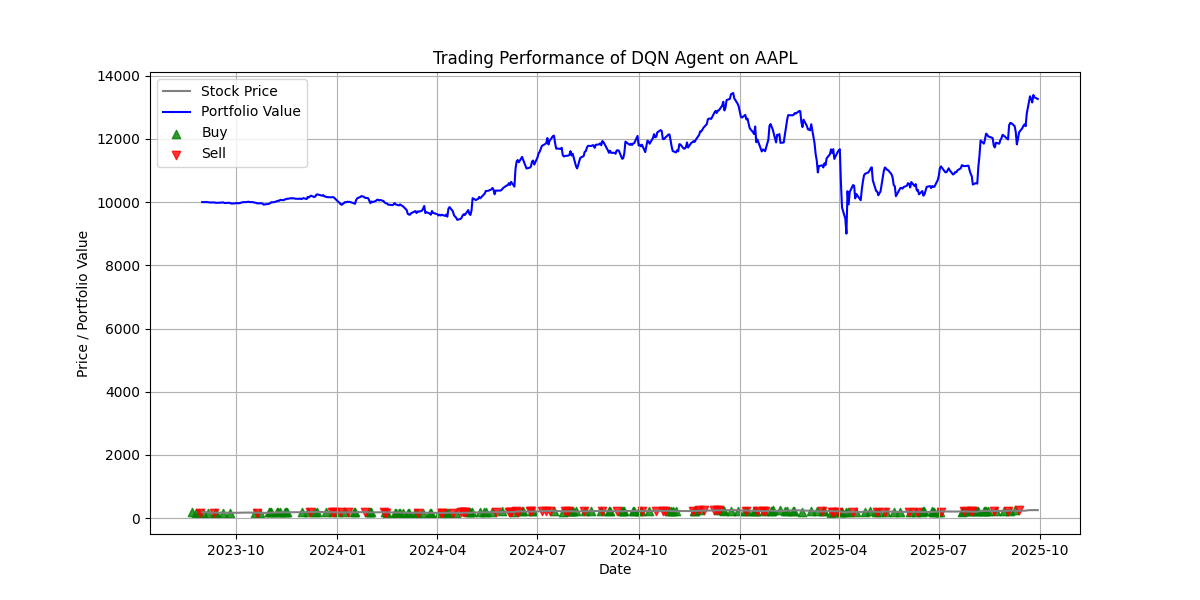

In [23]:
from IPython.display import Image, display
display(Image("trading_performance.png"))


In [27]:
!python train_agent.py
!python evaluate_agent.py

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
2025-10-12 17:32:25.573930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760290345.593428   15353 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760290345.599377   15353 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760290345.614682   15353 computation_placer.cc:177] computati

In [26]:
%%writefile train_agent.py
import gym
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from trading_env import TradingEnv
from data_utils import load_and_process
import torch

def train(ticker='AAPL', total_timesteps=50000, window_size=10):
    df = load_and_process(ticker)
    split = int(len(df) * 0.8)
    train_df = df.iloc[:split].reset_index(drop=True)
    test_df = df.iloc[split:].reset_index(drop=True)

    env = DummyVecEnv([lambda: TradingEnv(train_df, window_size=window_size)])
    policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=[256, 256])

    model = DQN('MlpPolicy', env,
                learning_rate=1e-4,
                buffer_size=100000,
                learning_starts=1000,
                batch_size=64,
                tau=1.0,
                gamma=0.99,
                train_freq=4,
                target_update_interval=1000,
                policy_kwargs=policy_kwargs,
                verbose=1,
                tensorboard_log="./tb_logs/")

    model.learn(total_timesteps=total_timesteps)
    model.save(f"dqn_{ticker}")
    print("✅ Training complete and model saved.")
    return model, train_df, test_df

if __name__ == "__main__":
    train('AAPL', total_timesteps=40000)


Writing train_agent.py


Using cuda device
Logging to ./tb_logs/DQN_3


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 553      |
|    time_elapsed     | 15       |
|    total_timesteps  | 8444     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.71e+04 |
|    n_updates        | 1860     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 535      |
|    time_elapsed     | 31       |
|    total_timesteps  | 16888    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.88e+04 |
|    n_updates        | 3971     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 534      |
|    time_elapsed     | 47       |
|    total_timesteps  | 25332    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.86e+04 |
|    n_updates        | 6082     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16       |
|    fps              | 534      |
|    time_elapsed     | 63       |
|    total_timesteps  | 33776    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.01e+04 |
|    n_updates        | 8193     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

✅ Training complete and model saved.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

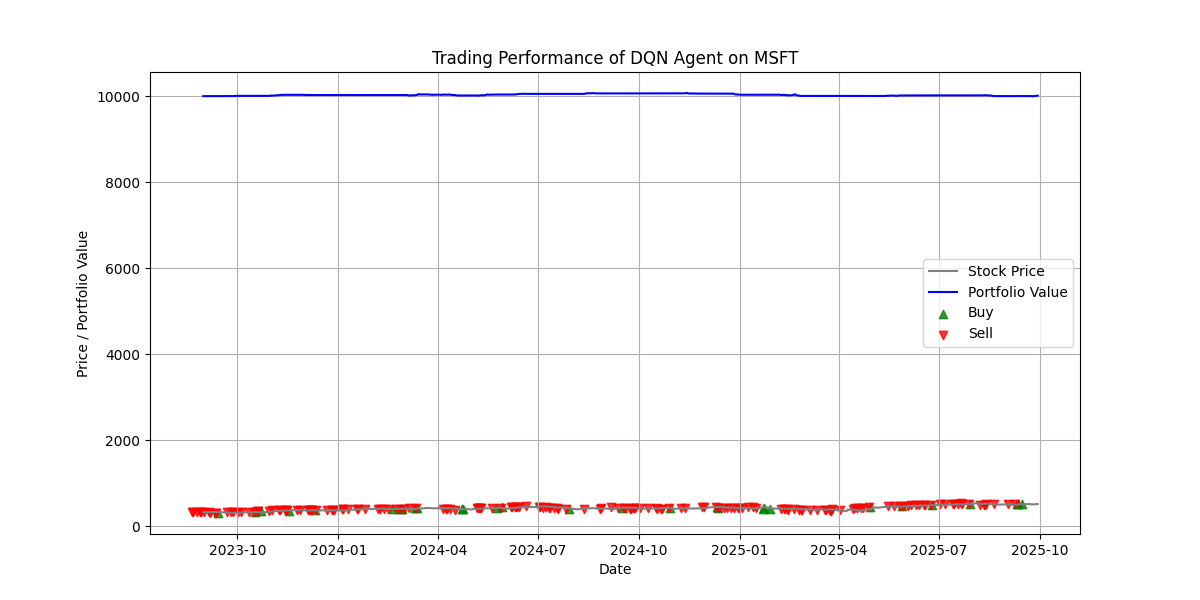

Using cuda device
Logging to ./tb_logs/DQN_4


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 589      |
|    time_elapsed     | 14       |
|    total_timesteps  | 8444     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.71e+05 |
|    n_updates        | 1860     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 543      |
|    time_elapsed     | 31       |
|    total_timesteps  | 16888    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.48e+05 |
|    n_updates        | 3971     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 536      |
|    time_elapsed     | 47       |
|    total_timesteps  | 25332    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.43e+05 |
|    n_updates        | 6082     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16       |
|    fps              | 533      |
|    time_elapsed     | 63       |
|    total_timesteps  | 33776    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.94e+05 |
|    n_updates        | 8193     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

✅ Training complete and model saved.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

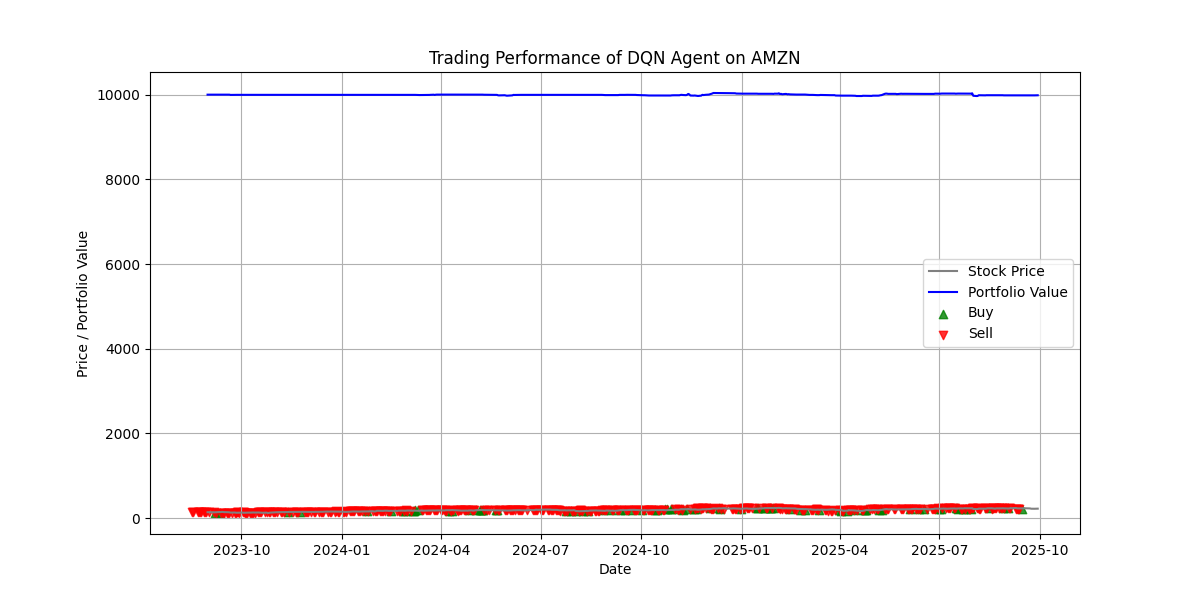

Using cuda device
Logging to ./tb_logs/DQN_5


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 557      |
|    time_elapsed     | 15       |
|    total_timesteps  | 8444     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.76e+05 |
|    n_updates        | 1860     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 528      |
|    time_elapsed     | 31       |
|    total_timesteps  | 16888    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.78e+05 |
|    n_updates        | 3971     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 521      |
|    time_elapsed     | 48       |
|    total_timesteps  | 25332    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.72e+05 |
|    n_updates        | 6082     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16       |
|    fps              | 515      |
|    time_elapsed     | 65       |
|    total_timesteps  | 33776    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.31e+05 |
|    n_updates        | 8193     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

✅ Training complete and model saved.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

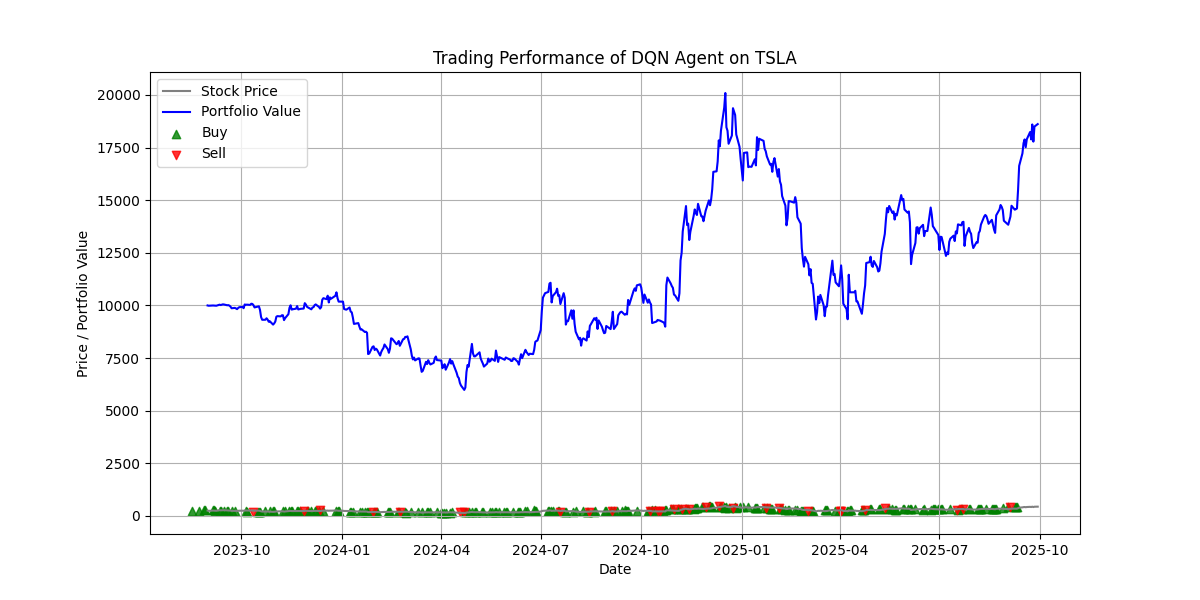

In [28]:
from train_agent import train
from evaluate_agent import evaluate_model

for ticker in ["MSFT", "AMZN", "TSLA"]:
    model, train_df, test_df = train(ticker, total_timesteps=40000)
    evaluate_model(ticker)

In [29]:
!pip install plotly


In [30]:
%%writefile dashboard.py
import plotly.graph_objects as go
import numpy as np

def plot_trading_dashboard(dates, prices, portfolio_values, actions, rewards, q_values, ticker='AAPL'):
    """
    Visualizes trading performance using Plotly.
    """

    buy_idx = [i for i, a in enumerate(actions) if a == 1]
    sell_idx = [i for i, a in enumerate(actions) if a == 2]

    fig = go.Figure()

    # --- 1️⃣ Stock Price ---
    fig.add_trace(go.Scatter(
        x=dates, y=prices,
        mode='lines', name='Stock Price',
        line=dict(color='gray', width=2)
    ))

    # --- 2️⃣ Portfolio Value ---
    fig.add_trace(go.Scatter(
        x=dates, y=portfolio_values,
        mode='lines', name='Portfolio Value',
        line=dict(color='blue', width=2)
    ))

    # --- 3️⃣ Buy/Sell Markers ---
    fig.add_trace(go.Scatter(
        x=np.array(dates)[buy_idx],
        y=np.array(prices)[buy_idx],
        mode='markers', name='Buy',
        marker=dict(color='green', size=10, symbol='triangle-up')
    ))

    fig.add_trace(go.Scatter(
        x=np.array(dates)[sell_idx],
        y=np.array(prices)[sell_idx],
        mode='markers', name='Sell',
        marker=dict(color='red', size=10, symbol='triangle-down')
    ))

    # --- 4️⃣ Reward Over Time ---
    fig.add_trace(go.Scatter(
        x=dates, y=rewards,
        mode='lines', name='Reward',
        line=dict(color='orange', width=1.5, dash='dot'),
        yaxis="y2"
    ))

    # --- 5️⃣ Q-values (Confidence) ---
    fig.add_trace(go.Scatter(
        x=dates, y=q_values,
        mode='lines', name='Agent Q-Value (Confidence)',
        line=dict(color='purple', width=1.5, dash='dash'),
        yaxis="y3"
    ))

    # Layout setup
    fig.update_layout(
        title=f"📊 Trading Dashboard for {ticker}",
        xaxis_title="Date",
        yaxis=dict(title="Price / Portfolio Value"),
        yaxis2=dict(title="Reward", overlaying="y", side="right", showgrid=False),
        yaxis3=dict(title="Q-Value", overlaying="y", side="right", position=1.05, showgrid=False),
        legend=dict(x=0, y=1.15, orientation="h"),
        template="plotly_white",
        height=700
    )

    fig.show()


Writing dashboard.py


In [31]:
!python evaluate_agent.py


2025-10-12 17:46:53.634179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760291213.655051   19064 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760291213.661319   19064 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760291213.677665   19064 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760291213.677691   19064 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760291213.677697   19064 computation_placer.cc:177] computation placer alr

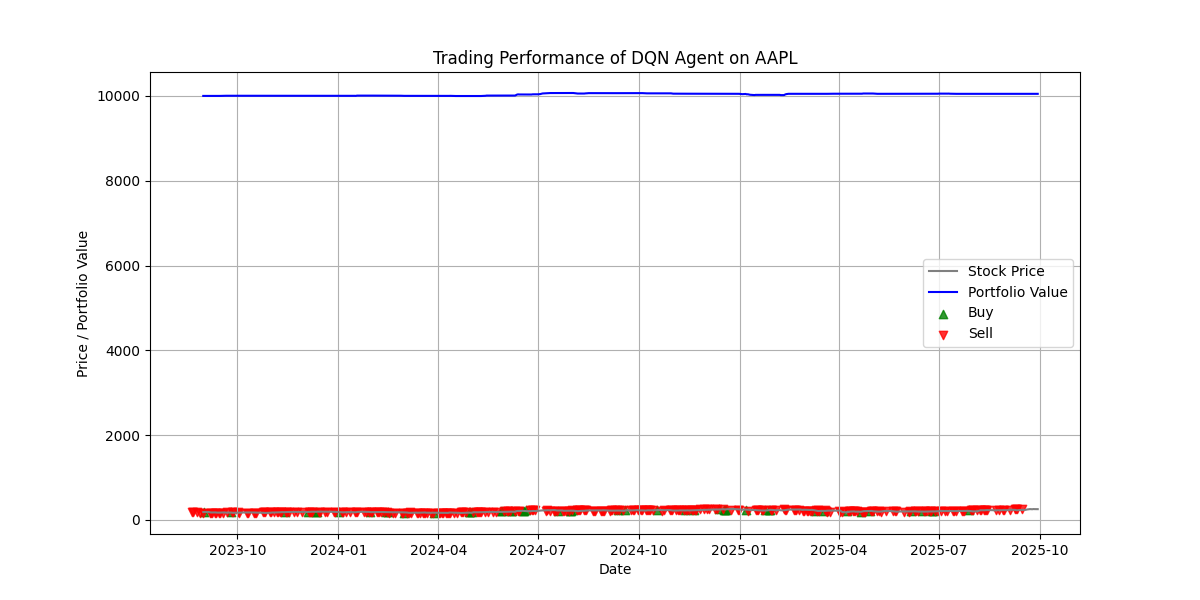

In [32]:
from IPython.display import Image, display
display(Image("trading_performance.png"))
